<a href="https://colab.research.google.com/github/san-11/fraud-detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
df = pd.read_csv('Fraud.csv')
print(df.shape)
print(df.head())

(4288924, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4288924 entries, 0 to 4288923
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 359.9+ MB


In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           1
isFlaggedFraud    1
dtype: int64

As evident from the Data Dictionary, Merchant recipient records does not provide values for attributes: oldbalanceDest and newbalanceDest.
Therefore, the transaction amount received by the recipient cannot be checked for detection of fraudulant activites. This might skewer the output of machine learning model for predicting Fraud in transactions.

In [ ]:
df['isFraud'].value_counts()

0.0    4285454
1.0       3469
Name: isFraud, dtype: int64

the dataset is highly unbalanced

0--> normal transactions

1-->fraudlent transactions

isFraud Column shows that the classes are imbalanced. This is important because if we build a machine learning model on this highly skewed data, the non-fraudulent transactions will influence the training of the model almost entirely, thus affecting the results.

In [ ]:
#seperating data for analysis
legit=df[df.isFraud == 0]
fraud=df[df.isFraud == 1]
print(legit.shape)
print(fraud.shape)

(4285454, 11)
(3469, 11)


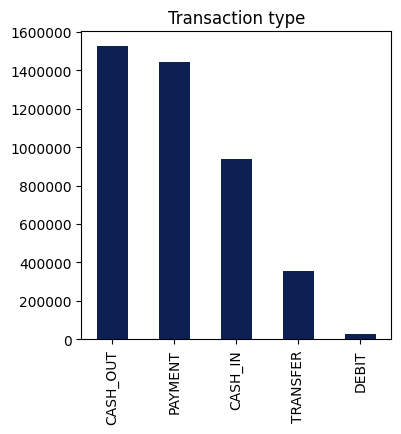

In [ ]:
#Visualizing Type column
f, ax = plt.subplots(1, 1)
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(4,4),color = "#0c2054")
plt.ticklabel_format(style='plain', axis='y')

In [ ]:
df_new = df[df['nameDest'].str.contains('M') == False]
df_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.00,1.0,0.0
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0.0,0.0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0.0,0.0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0.0,0.0


In [ ]:
total_transactions = len(df_new)
fraud_transactions = len(df_new[df_new.isFraud == 1])
print(fraud_transactions)
print(total_transactions)
print("Percent of fraud transactions is: {:.4f} %".format((fraud_transactions * 100)/ total_transactions))

3469
2846373
Percent of fraud transactions is: 0.1219 %


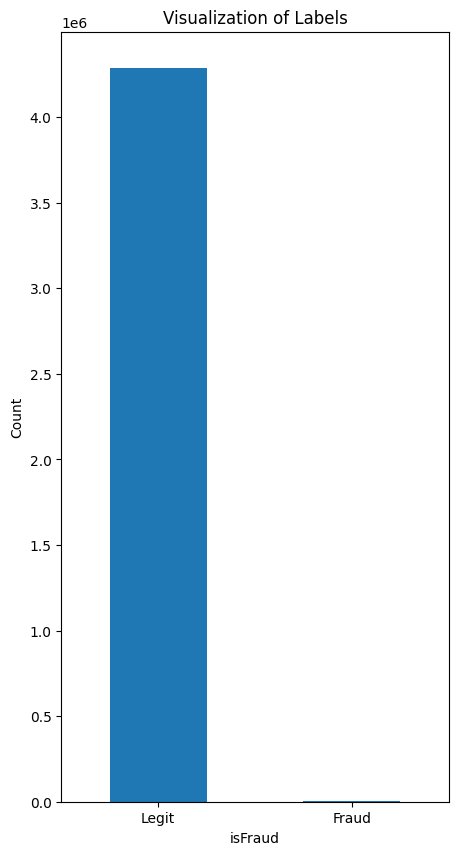

In [ ]:
#Number of Legit and Fraud Transactions
plt.figure(figsize=(5,10))
labels=["Legit","Fraud"]
count_classes=df.value_counts(df['isFraud'],sort=True)
count_classes.plot(kind="bar",rot=0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2),labels)
plt.show()

It is evident that number of fraud detected transactions is very low. This creates a unbalanced relationship between fraud and real transactions. This type of classification should be done by Random Forest Classifier Algorithm

<ipython-input-20-e37d4c91d0e8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df_new.corr()


<Axes: >

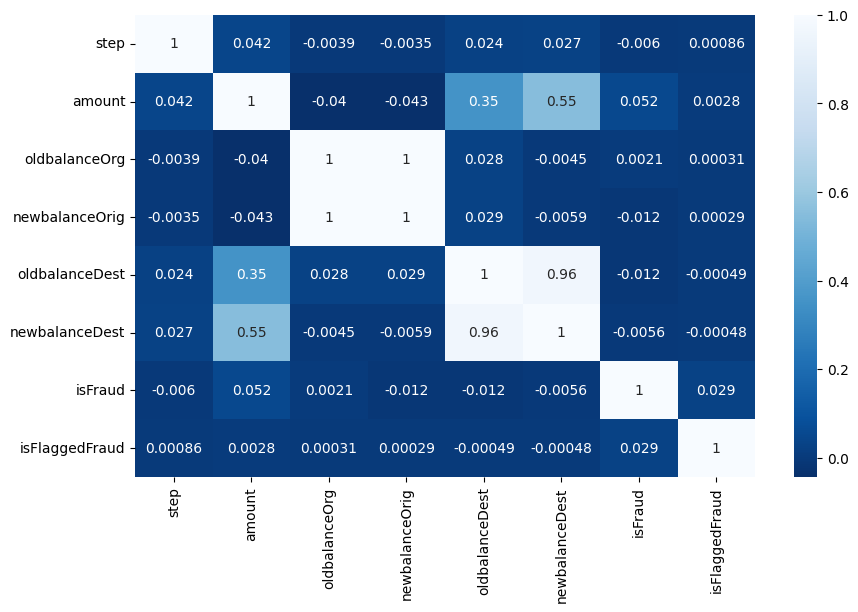

In [ ]:
correlation = df_new.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation,annot=True, cmap='Blues_r')

Based on the above heatmap, it is evident that there is a  direct correlation between oldbalanceOrig and newbalanceOrig. Similarly, oldbalanceDest and newbalanceDest also exhibit a high correlation, as indicated by correlation values close to 1. To ensure the accuracy of the machine learning model, it is necessary to either remove or transform these columns to prevent any bias in the final output of the model.

There are 3 attributes that are object data type. Thus we need to convert it to numeric values to chec for multicollinearity

In [ ]:
objList = df_new.select_dtypes(include = "object").columns

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for att in objList:
    df_new[att] = encoder.fit_transform(df_new[att].astype(str))

print(df_new.head())

<ipython-input-21-7561912013f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[att] = encoder.fit_transform(df_new[att].astype(str))
<ipython-input-21-7561912013f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[att] = encoder.fit_transform(df_new[att].astype(str))


    step  type     amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
2      1     3     181.00    448962          181.0            0.00    296650   
3      1     1     181.00   2609276          181.0            0.00    264223   
9      1     2    5337.77   2420494        41720.0        36382.23    191001   
10     1     2    9644.94   1324201         4465.0            0.00    385092   
15     1     1  229133.94   2704834        15325.0            0.00    281472   

    oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2              0.0            0.00      1.0             0.0  
3          21182.0            0.00      1.0             0.0  
9          41898.0        40348.79      0.0             0.0  
10         10845.0       157982.12      0.0             0.0  
15          5083.0        51513.44      0.0             0.0  


<ipython-input-21-7561912013f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[att] = encoder.fit_transform(df_new[att].astype(str))


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multiCollinearity(df_new):
    vif = pd.DataFrame()
    vif["variables"] = df_new.columns
    for i in range(df_new.shape[1]):
        vif["VIF"] = variance_inflation_factor(df_new.values, i)
    return(vif)

check_multiCollinearity(df_new)

,variables,VIF
0,step,1.000987
1,type,1.000987
2,amount,1.000987
3,nameOrig,1.000987
4,oldbalanceOrg,1.000987
5,newbalanceOrig,1.000987
6,nameDest,1.000987
7,oldbalanceDest,1.000987
8,newbalanceDest,1.000987
9,isFraud,1.000987


Based on the high VIF values observed for oldbalanceOrg and newbalanceOrig, it is evident that these attributes are strongly correlated. The same is true for oldbalanceDest and newbalanceDest. Additionally, there is a connection between nameDest and nameOrig.

Therefore, we should merge these pairs of collinear attributes and remove the individual ones from the dataset.

In [ ]:
df_new['Actual_amount_orig'] = df_new.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
df_new['Actual_amount_dest'] = df_new.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
df_new['TransactionPath'] = df_new.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

<ipython-input-23-967496b0282b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Actual_amount_orig'] = df_new.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
<ipython-input-23-967496b0282b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Actual_amount_dest'] = df_new.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
<ipython-input-23-967496b0282b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

removing the previous columns.

In [ ]:
df_new = df_new.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

Calculating the multicollinearity again

In [ ]:
check_multiCollinearity(df_new)

,variables,VIF
0,type,2.001745
1,amount,2.001745
2,isFraud,2.001745
3,isFlaggedFraud,2.001745
4,Actual_amount_orig,2.001745
5,Actual_amount_dest,2.001745
6,TransactionPath,2.001745


<Axes: >

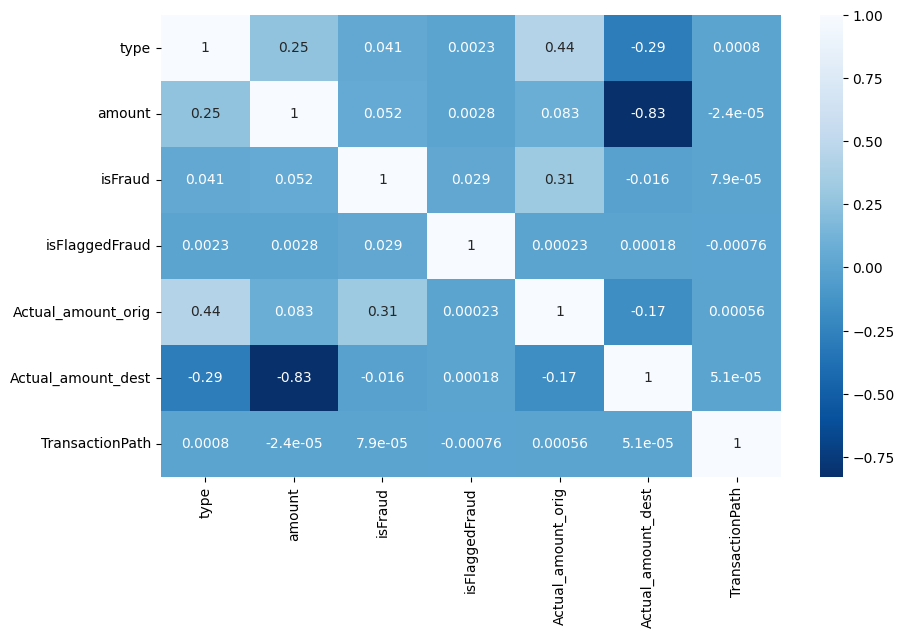

In [ ]:
correlation = df_new.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation,annot=True, cmap='Blues_r')

In [ ]:
scaler = StandardScaler()
df_new["NormalizedAmount"] = scaler.fit_transform(df_new["amount"].values.reshape(-1, 1))
df_new.drop(["amount"], inplace= True, axis= 1)

Y = df_new["isFraud"]
X = df_new.drop(["isFraud"], axis= 1)

In [ ]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (1992461, 6)
Shape of X_test:  (853912, 6)


In [ ]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

In [ ]:
# Print score
print("Random Forest Score: ", random_forest_score)

Random Forest Score:  99.9573726566672


In [ ]:
# confusion matrix - RF

conf_matrix = confusion_matrix(Y_test, Y_pred_rf.round())
print(conf_matrix)

[[852812     28]
 [   336    736]]


##Values in the confusion matrix denotes:

852812: True Positive: Transactions which were fraud are predicted as fraud

28: False positive: Transactions which were not fraud are predicted as fraud

336: False negative: Transactions which were fraud are predicted as not fraud

736: True negative: Transactions which were not fraud and also predicted as not fraud

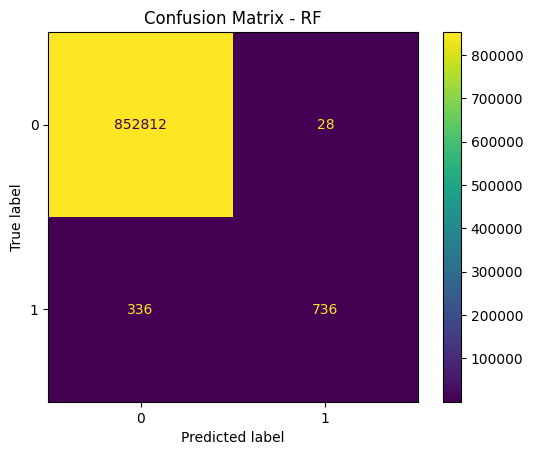

In [ ]:
# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

In [ ]:
rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(rf)

Classification Report - Random Forest
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    852840
         1.0       0.96      0.69      0.80      1072

    accuracy                           1.00    853912
   macro avg       0.98      0.84      0.90    853912
weighted avg       1.00      1.00      1.00    853912



# CONCLUSION

Given the dataset's significant imbalance towards one class, Random Forest is the preferred algorithm to forecast fraudulent transactions. The data undergoes testing in multiple decision trees, resulting in effective calibration.

#Questions.

## Data cleaning including missing values, outliers and multi-collinearity.
Based on the nature of transactions, it is evident that the recipient's balance information is essential for fraud verification in transactions. As a result, we had to segregate transactions involving Merchant accounts due to the unavailability of their old and new balance data.

Additionally,I examined the presence of multicollinearity among the columns and identify the crucial factors for detecting fraud in account transactions.

## How did you select variables to be included in the model?
I determined the variables to include in the training and testing of the model by examining the Variance Inflation Factor (VIF). Attributes demonstrating high correlation with the output of the machine learning model, specifically the "isFraud" column, are considered for inclusion.

## What are the key factors that predict fraudulent customer?
Unusual and unusually large transaction amounts can potentially signal fraud, as fraudsters often seek to steal substantial sums of money.

Sudden and significant alterations in transaction patterns, such as a sudden surge in transaction volume or size, can serve as warning signs of fraudulent activity.

Additionally, if the transaction amount matches the old balance of the sender's account, it may indicate suspicious behavior.

## Do these factors make sense? If yes, How? If not, How not?
Transactions are conducted based on a sequence of events. When a customer consistently engages in transactions of similar amounts, it typically suggests regular purchases of commonly used goods. Therefore, a sudden surge in transaction amount could indicate fraudulent activity by an agent.

Both individual and merchant accounts tend to exhibit trends over time. If a transaction deviates from the established trend, it may be indicative of fraudulent activity.


## What kind of prevention should be adopted while company update its infrastructure?
To prevent fraud, the company could implement measures such as transaction monitoring, account monitoring, and two-factor authentication. Additionally, the company could also train its employees to identify and report suspicious activity.

## Assuming these actions have been implemented, how would you determine if they work?
To determine if these actions are effective, the company could track the number of fraudulent transactions before and after the implementation of these measures. Additionally, the company could also conduct regular audits and assessments to identify any areas where the system may be vulnerable to fraud.